In [1]:
# Import necessary libraries for visualization, numerical operations, and quantum machine learning
import matplotlib.pyplot as plt
import numpy as np
from pennylane import numpy as pnp
from tqdm import tqdm
import pennylane as qml
import tensorflow as tf
from tensorflow import keras

2023-12-16 14:50:27.970319: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-16 14:50:27.999573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 14:50:27.999611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 14:50:28.000240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 14:50:28.004147: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-16 14:50:28.004713: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Set the random seed for reproducibility
np.random_seed = 42

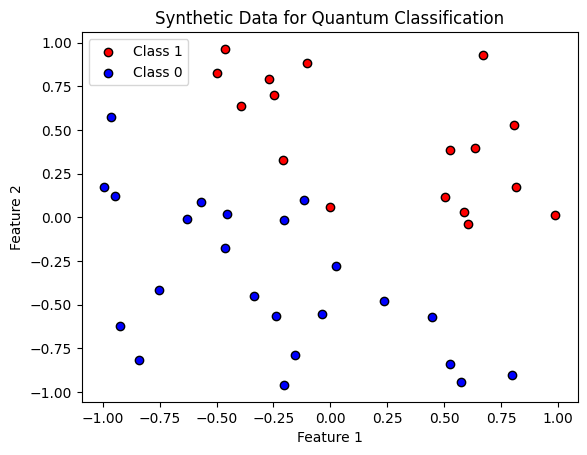

In [3]:
# Define the number of input features and number of samples
num_inputs = 2
num_samples = 40

# Generate random samples for training data
X = 2 * np.random.random((num_samples, num_inputs)) - 1

# Calculate the target labels based on the sum of features
y = np.sum(X, axis=1) >= 0  # True if sum is non-negative, False otherwise
# y_one_hot = np.zeros((num_samples, 2), dtype=int)
# y_one_hot[np.arange(num_samples), y.astype(int)] = 1
y = y.astype("int32")
y = y * 2 - 1
# Plotting the generated synthetic data
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='r', marker='o', edgecolors='k', label="Class 1")
plt.scatter(X[y == -1, 0], X[y == -1, 1], c='b', marker='o', edgecolors='k', label="Class 0")
plt.title("Synthetic Data for Quantum Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [4]:
# set the device
device = qml.device("default.qubit", wires=2)

In [5]:
def quantum_circuit(W):
    qml.CNOT(wires=[1, 0])
    
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    
    qml.CNOT(wires=[0, 1])

In [6]:
def preprocessing(x):
    qml.AngleEmbedding(x, wires=[0, 1])

In [7]:
@qml.qnode(device, diff_method="parameter-shift", max_diff=4)
def layer(weights, x):
    preprocessing(x)
    
    for W in weights:
        quantum_circuit(W)
    return qml.expval(qml.PauliZ(0))

In [8]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [9]:
def classifier(weight, bias, x):
    return layer(weight, x) + bias

In [10]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [11]:
def cost(weights, bias, X, Y):
    predictions = [classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [12]:
X = pnp.array(X[:], requires_grad=False)
Y = pnp.array(y[:], requires_grad=False)

In [13]:
pnp.random.seed(0)
num_qubits = 2
num_layers = 3
weights_init = 0.01 * pnp.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = pnp.array(0.0, requires_grad=True)
print(weights_init, bias_init)

[[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]]

 [[ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]]] 0.0


/tmp/ipykernel_6068/562676348.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


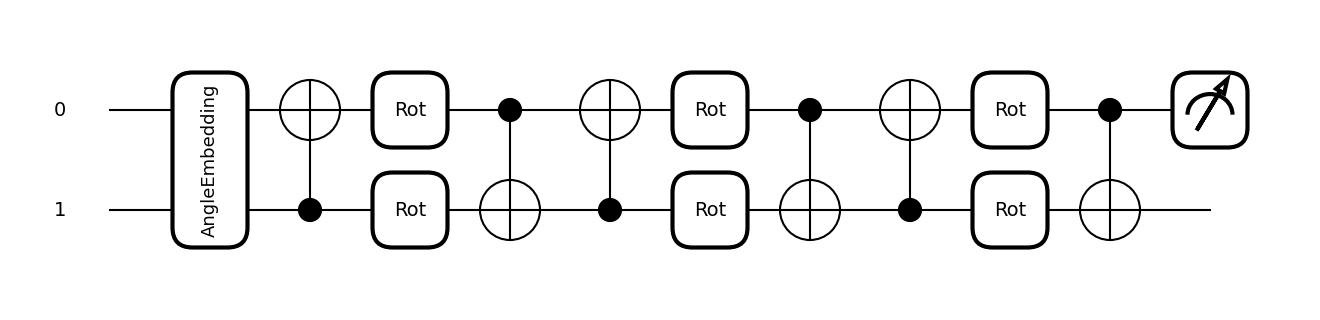

In [14]:
fig, ax = qml.draw_mpl(layer)(weights_init, X[0])
fig.show()

In [15]:
learning_rate = 0.02
# opt = qml.NesterovMomentumOptimizer(0.05)
batch_size = 4

In [16]:
weights = weights_init
bias = bias_init
for epoch in range(20):
    
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    
    grad_fn = qml.grad(cost)
    weights_grads, bias_grads = grad_fn(weights, bias, X_batch, Y_batch)
    bias = bias - bias_grads * learning_rate
    weights = weights - weights_grads * learning_rate
    

    # Compute accuracy
    predictions = [np.sign(classifier(weights, bias, x)) for x in X]
    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            epoch + 1, cost(weights, bias, X, Y), acc
        )
    )

Iter:     1 | Cost: 1.9008412 | Accuracy: 0.4250000 
Iter:     2 | Cost: 1.8419590 | Accuracy: 0.4250000 
Iter:     3 | Cost: 1.7550217 | Accuracy: 0.4250000 
Iter:     4 | Cost: 1.7118687 | Accuracy: 0.4250000 
Iter:     5 | Cost: 1.6295993 | Accuracy: 0.4250000 
Iter:     6 | Cost: 1.5809424 | Accuracy: 0.4250000 
Iter:     7 | Cost: 1.4850595 | Accuracy: 0.4250000 
Iter:     8 | Cost: 1.4539806 | Accuracy: 0.4250000 
Iter:     9 | Cost: 1.3994896 | Accuracy: 0.4250000 
Iter:    10 | Cost: 1.3967246 | Accuracy: 0.4250000 
Iter:    11 | Cost: 1.3933037 | Accuracy: 0.4250000 
Iter:    12 | Cost: 1.3640091 | Accuracy: 0.4250000 
Iter:    13 | Cost: 1.3000732 | Accuracy: 0.4250000 
Iter:    14 | Cost: 1.2610243 | Accuracy: 0.4250000 
Iter:    15 | Cost: 1.2681317 | Accuracy: 0.4250000 
Iter:    16 | Cost: 1.2315967 | Accuracy: 0.4250000 
Iter:    17 | Cost: 1.1855137 | Accuracy: 0.4250000 
Iter:    18 | Cost: 1.1736626 | Accuracy: 0.4250000 
Iter:    19 | Cost: 1.1278547 | Accuracy: 0.50

In [17]:
X_val = 2 * np.random.random((1000, 2)) - 1
y_val = np.sum(X_val, axis=1) >= 0  # Generate labels for the test data
y_val = y_val * 2 -1

In [18]:
opt = qml.NesterovMomentumOptimizer(0.01)

In [19]:
y_pred = np.sign(classifier(weights, bias, X_val))

In [20]:
accuracy(y_val, y_pred)

0.486

In [21]:
weights = weights_init
bias = bias_init
for epoch in range(10):
    
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.sign(classifier(weights, bias, x)) for x in X]
    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            epoch + 1, cost(weights, bias, X, Y), acc
        )
    )

Iter:     1 | Cost: 1.9387269 | Accuracy: 0.4250000 
Iter:     2 | Cost: 1.8601490 | Accuracy: 0.4250000 
Iter:     3 | Cost: 1.7495895 | Accuracy: 0.4250000 
Iter:     4 | Cost: 1.6178673 | Accuracy: 0.4250000 
Iter:     5 | Cost: 1.4914615 | Accuracy: 0.4250000 
Iter:     6 | Cost: 1.3787430 | Accuracy: 0.4250000 
Iter:     7 | Cost: 1.2800796 | Accuracy: 0.4250000 
Iter:     8 | Cost: 1.1967268 | Accuracy: 0.4250000 
Iter:     9 | Cost: 1.1227844 | Accuracy: 0.4750000 
Iter:    10 | Cost: 1.0618821 | Accuracy: 0.5000000 


In [22]:
X_val = 2 * np.random.random((1000, 2)) - 1
y_val = np.sum(X_val, axis=1) >= 0  # Generate labels for the test data
y_val = y_val * 2 -1

In [23]:
y_pred = np.sign(classifier(weights, bias, X_val))

In [24]:
accuracy(y_val, y_pred)

0.484

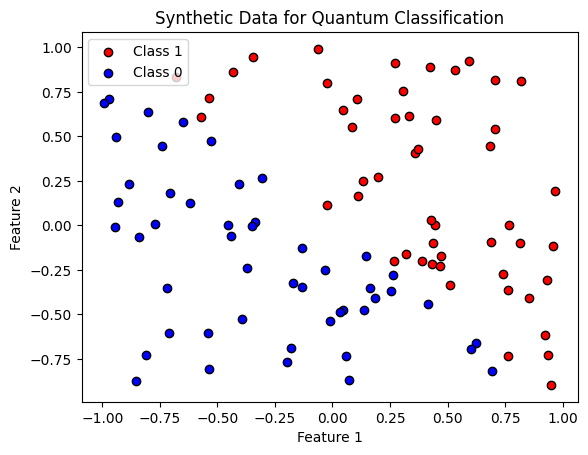

In [25]:
# Define the number of input features and number of samples
num_inputs = 2
num_samples = 100

# Generate random samples for training data
X = 2 * np.random.random((num_samples, num_inputs)) - 1

# Calculate the target labels based on the sum of features
y = np.sum(X, axis=1) >= 0  # True if sum is non-negative, False otherwise
y_one_hot = np.zeros((num_samples, 2), dtype=int)
y_one_hot[np.arange(num_samples), y.astype(int)] = 1

# Plotting the generated synthetic data
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='r', marker='o', edgecolors='k', label="Class 1")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='b', marker='o', edgecolors='k', label="Class 0")
plt.title("Synthetic Data for Quantum Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [26]:
def quantum_circuit(W):
    qml.CNOT(wires=[1, 0])

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    #qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)

    qml.CNOT(wires=[0, 1])

In [27]:
def preprocessing(x):
    qml.AngleEmbedding(x, wires=[0, 1])

In [28]:
from pennylane import AngleEmbedding, StronglyEntanglingLayers

device = qml.device("default.qubit.tf", wires=2)
@qml.qnode(device, interface="tf", )
def layer(weights, inputs):
    AngleEmbedding(inputs, wires=range(num_qubits))
    #StronglyEntanglingLayers(weights, wires=range(num_qubits))
    
    for weight in weights:
        quantum_circuit(weight)
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

2023-12-16 14:50:45.756768: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 14:50:45.756979: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [29]:
num_qubits = 2
num_layers = 2
epochs = 30

In [30]:
qlayer = qml.qnn.KerasLayer(layer, {"weights": (num_layers, num_qubits, 3)}, output_dim=num_qubits)
qlayer.trainable = True

In [31]:
preprocessing = tf.keras.layers.Dense(2, name="preprocessing", activation=None)
conplex_to_float = tf.keras.layers.Lambda(lambda x: tf.math.real(x), tf.float32)
classical_output = tf.keras.layers.Dense(2, activation="softmax")
model = tf.keras.models.Sequential([qlayer, classical_output])

In [32]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer, loss="mse", metrics=["categorical_accuracy"])#categorical_crossentropy

loss_fn = tf.keras.losses.MeanSquaredError()

In [33]:
fitting = model.fit(X, y_one_hot, epochs=30, batch_size=2, validation_split=0.2, verbose=1)

Epoch 1/30
40/40 [==============================] - 2s 57ms/step - loss: 0.4307 - categorical_accuracy: 0.4625 - val_loss: 0.3171 - val_categorical_accuracy: 0.6000
Epoch 2/30
40/40 [==============================] - 2s 61ms/step - loss: 0.4180 - categorical_accuracy: 0.4625 - val_loss: 0.3070 - val_categorical_accuracy: 0.6000
Epoch 3/30
40/40 [==============================] - 2s 55ms/step - loss: 0.4022 - categorical_accuracy: 0.4625 - val_loss: 0.2950 - val_categorical_accuracy: 0.6000
Epoch 4/30
40/40 [==============================] - 2s 53ms/step - loss: 0.3829 - categorical_accuracy: 0.4625 - val_loss: 0.2821 - val_categorical_accuracy: 0.6000
Epoch 5/30
40/40 [==============================] - 2s 53ms/step - loss: 0.3605 - categorical_accuracy: 0.4625 - val_loss: 0.2683 - val_categorical_accuracy: 0.6000
Epoch 6/30
40/40 [==============================] - 2s 54ms/step - loss: 0.3357 - categorical_accuracy: 0.4625 - val_loss: 0.2533 - val_categorical_accuracy: 0.6000
Epoch 7/30

In [34]:
model.evaluate(X, y_one_hot, batch_size=8)

13/13 [==============================] - 0s 22ms/step - loss: 0.1312 - categorical_accuracy: 0.9200


[0.1311899721622467, 0.9200000166893005]

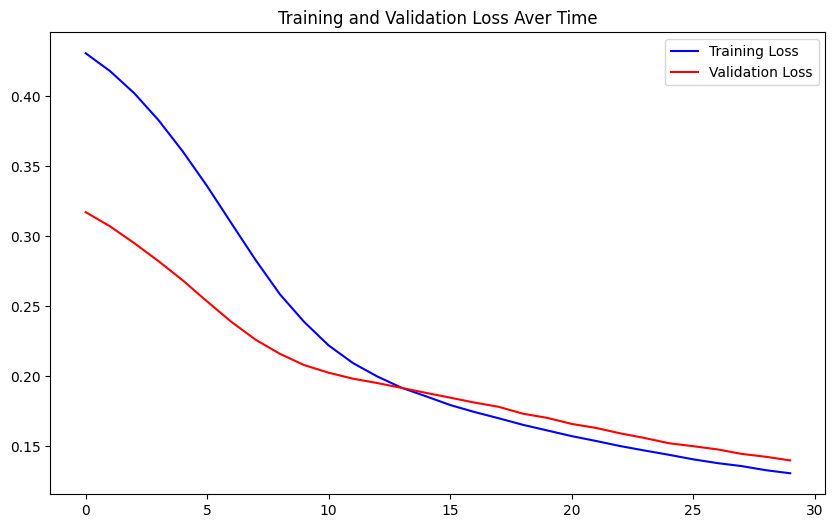

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(fitting.history['loss']), "-b", label="Training Loss")
plt.plot(np.array(fitting.history['val_loss']), "-r", label="Validation Loss")
plt.title("Training and Validation Loss Aver Time")
plt.legend()
plt.show()

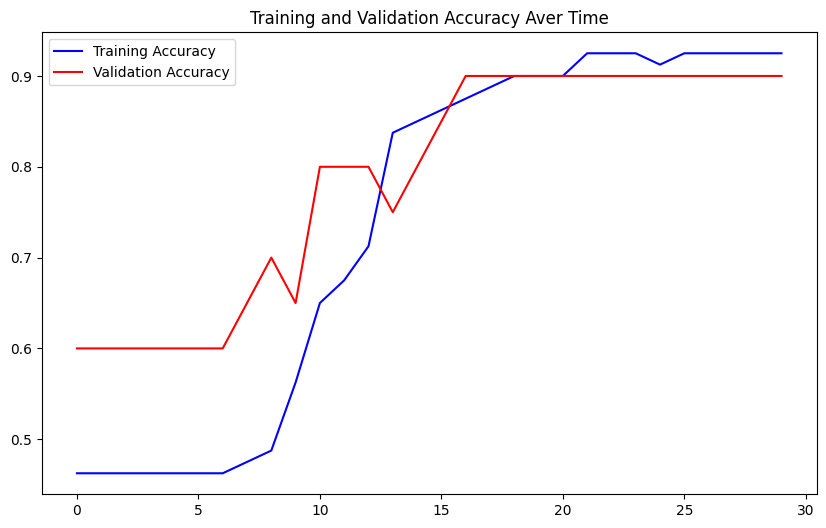

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(fitting.history['categorical_accuracy']), "-b", label="Training Accuracy")
plt.plot(np.array(fitting.history['val_categorical_accuracy']), "-r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy Aver Time")
plt.legend()
plt.show()